In [3]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator, cg
from scipy.optimize._linesearch import scalar_search_wolfe2
from datetime import datetime
from collections import defaultdict




class LineSearchTool(object):
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError(f'Unknown method {method}')

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        if self._method == 'Constant':
            return self.c

        alpha_0 = self.alpha_0 if previous_alpha is None else previous_alpha
        phi_0 = oracle.func(x_k)
        grad_0 = oracle.grad(x_k)
        phi_0_deriv = np.dot(grad_0, d_k)

        if self._method == 'Wolfe':
            res = scalar_search_wolfe2(
                phi=lambda a: oracle.func(x_k + a * d_k),
                derphi=lambda a: np.dot(oracle.grad(x_k + a * d_k), d_k),
                c1=self.c1, c2=self.c2
            )
            alpha = res[0]
            if alpha is None:
                # fallback на Armijo
                alpha = self.alpha_0
                while oracle.func(x_k + alpha * d_k) > phi_0 + self.c1 * alpha * phi_0_deriv:
                    alpha *= 0.5
            return alpha

        elif self._method == 'Armijo':
            alpha = alpha_0
            beta = 0.5
            while oracle.func(x_k + alpha * d_k) > phi_0 + self.c1 * alpha * phi_0_deriv:
                alpha *= beta
            return alpha


def get_line_search_tool(line_search_options=None):
    if isinstance(line_search_options, LineSearchTool):
        return line_search_options
    elif isinstance(line_search_options, dict):
        return LineSearchTool(**line_search_options)
    else:
        return LineSearchTool()



from datetime import datetime
from collections import defaultdict
import numpy as np

def gradient_descent_sparse(oracle, x_0, tolerance=1e-5, max_iter=10000,
                            line_search_options=None, trace=False, display=False):

    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = x_0.copy()
    start_time = datetime.now()

    for k in range(max_iter):
        grad = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad)


        if grad_norm <= tolerance:
            if trace:
                history['iterations'] = k
            return x_k, 'success', history

        d_k = -grad


        alpha_k = line_search_tool.line_search(oracle, x_k, d_k)
        if alpha_k is None or alpha_k < 1e-16:
            if trace:
                history['iterations'] = k
            return x_k, 'line_search_fail', history


        x_k = x_k + alpha_k * d_k


        if trace:
            history['time'].append((datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(grad_norm)

        if display and k % 10 == 0:
            print(f"Iter {k:4d}: f={oracle.func(x_k):.6f}, ||grad||={grad_norm:.3e}, α={alpha_k:.3e}")


    if trace:
        history['iterations'] = max_iter
    return x_k, 'iterations_exceeded', history



def newton_sparse(oracle, x_0, tolerance=1e-5, max_iter=100,
                  line_search_options=None, trace=False, display=False, cg_tol=1e-5):
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = x_0.copy()
    start_time = datetime.now()

    for k in range(max_iter):
        grad = oracle.grad(x_k)
        grad_norm = np.linalg.norm(grad)
        if grad_norm ** 2 <= tolerance ** 2:
            return x_k, 'success', history

        n = len(x_k)
        H_linop = LinearOperator((n, n), matvec=lambda v: oracle.hess_vec(x_k, v))
        d_k, info = cg(H_linop, -grad, rtol=cg_tol, maxiter=n)
        if info != 0:
            print(f"⚠️ CG не сошёлся (info={info})")

        alpha_k = line_search_tool.line_search(oracle, x_k, d_k)
        if alpha_k is None:
            return x_k, 'line_search_fail', history

        x_k = x_k + alpha_k * d_k

        if trace:
            history['time'].append((datetime.now() - start_time).total_seconds())
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(grad_norm)
        if display and k % 5 == 0:
            print(f"Iter {k:3d}: f={oracle.func(x_k):.6e}, ||grad||={grad_norm:.3e}, α={alpha_k:.3e}")

    return x_k, 'iterations_exceeded', history


In [4]:
import numpy as np
import scipy.sparse as sp
from scipy.special import expit
from scipy.sparse.linalg import LinearOperator



class BaseSmoothOracle(object):


    def func(self, x):
        raise NotImplementedError('Func oracle not implemented.')

    def grad(self, x):
        raise NotImplementedError('Grad oracle not implemented.')

    def hess(self, x):
        raise NotImplementedError('Hessian oracle not implemented.')

    def func_directional(self, x, d, alpha):
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        return np.squeeze(self.grad(x + alpha * d).dot(d))




class QuadraticOracle(BaseSmoothOracle):

    def __init__(self, A, b):
        if sp.issparse(A):
            if not np.allclose(A.A.T, A.A):
                raise ValueError("A must be symmetric")
        elif not np.allclose(A, A.T):
            raise ValueError("A must be symmetric")
        self.A = A.tocsr() if sp.issparse(A) else A
        self.b = b

    def func(self, x):
        Ax = self.A.dot(x)
        return 0.5 * x.dot(Ax) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A



from scipy.special import expit

class SparseLogRegOracle(BaseSmoothOracle):
    def __init__(self, A, b, regcoef):

        self.A = A.tocsr()
        self.b = b
        self.regcoef = regcoef
        self.m = A.shape[0]

    def func(self, x):
        z = self.A.dot(x)
        return np.mean(np.logaddexp(0, -self.b * z)) + 0.5 * self.regcoef * np.dot(x, x)

    def grad(self, x):
        z = self.A.dot(x)
        sigma = expit(-self.b * z)
        weighted = self.b * sigma
        g = -(self.A.T.dot(weighted)) / self.m + self.regcoef * x
        return np.array(g).ravel()

    def hess_vec(self, x, v):

        z = self.A.dot(x)
        s = expit(self.b * z)
        D = s * (1 - s)
        Av = self.A.dot(v)
        ADv = D * Av
        return (self.A.T.dot(ADv)) / self.m + self.regcoef * v







def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):

    if sp.issparse(A):
        A = A.tocsr()
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)

        def matmat_ATsA(s):
            s = np.asarray(s).ravel()

            DA = A.multiply(s[:, np.newaxis])
            return A.T.dot(DA)

    else:
        A = np.asarray(A)
        matvec_Ax = lambda x: A.dot(x)
        matvec_ATx = lambda x: A.T.dot(x)

        def matmat_ATsA(s):
            s = np.asarray(s).ravel()
            return A.T.dot(s[:, np.newaxis] * A)

    if oracle_type == 'usual':
        oracle_cls = LogRegL2Oracle
    elif oracle_type == 'optimized':
        oracle_cls = LogRegL2OptimizedOracle
    else:
        raise ValueError(f'Unknown oracle_type={oracle_type}')

    return oracle_cls(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)




def grad_finite_diff(func, x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    n = x.size
    f0 = float(func(x))
    grad = np.zeros(n, dtype=float)
    for i in range(n):
        x_pert = x.copy()
        x_pert[i] += eps
        grad[i] = (float(func(x_pert)) - f0) / eps
    return grad


def hess_finite_diff(func, x, eps=1e-5):
    x = np.asarray(x, dtype=float)
    n = x.size
    H = np.zeros((n, n), dtype=float)
    f0 = float(func(x))
    f_ei = np.zeros(n)
    for i in range(n):
        x_i = x.copy()
        x_i[i] += eps
        f_ei[i] = float(func(x_i))

    for i in range(n):
        for j in range(i, n):
            x_ij = x.copy()
            x_ij[i] += eps
            x_ij[j] += eps
            f_ei_ej = float(func(x_ij))
            Hij = (f_ei_ej - f_ei[i] - f_ei[j] + f0) / (eps ** 2)
            H[i, j] = H[j, i] = Hij
    return H



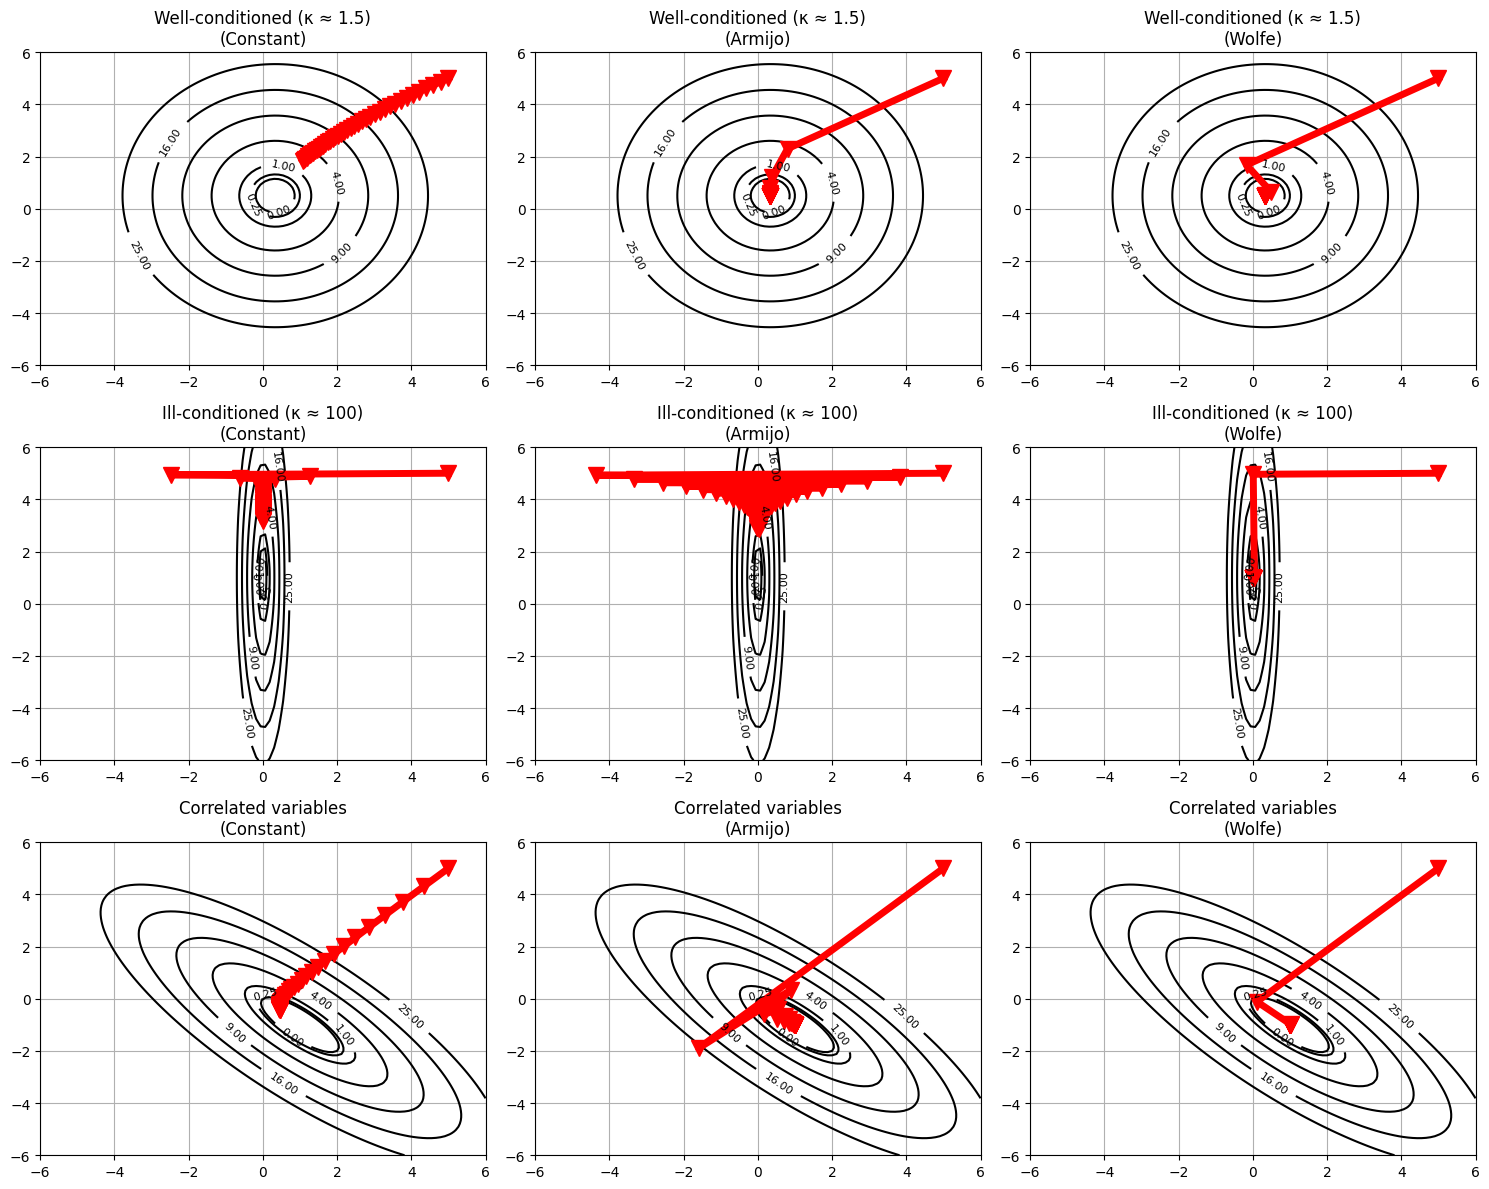

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp


from plot_trajectory_2d import plot_levels, plot_trajectory



A1 = np.array([[3, 0],
               [0, 2]])
b1 = np.array([1, 1])

A2 = np.array([[100, 0],
               [0, 1]])
b2 = np.array([1, 1])

A3 = np.array([[5, 4],
               [4, 5]])
b3 = np.array([1, -1])

functions = [
    (A1, b1, "Well-conditioned (κ ≈ 1.5)"),
    (A2, b2, "Ill-conditioned (κ ≈ 100)"),
    (A3, b3, "Correlated variables")
]


methods = [
    {"method": "Constant", "c": 0.015},
    {"method": "Armijo", "c1": 1e-4, "alpha_0": 0.3},
    {"method": "Wolfe", "c1": 1e-4, "c2": 0.9}
]

x0 = np.array([5.0, 5.0])

fig, axes = plt.subplots(len(functions), len(methods), figsize=(15, 12))

for i, (A, b, title) in enumerate(functions):
    oracle = QuadraticOracle(A, b)

    for j, opts in enumerate(methods):
        ax = axes[i, j]
        plt.sca(ax)


        x_opt, msg, hist = gradient_descent_sparse(
            oracle, x0,
            line_search_options=opts,
            trace=True
        )


        if 'x' not in hist:
            hist['x'] = [x0.copy()]
            x_k = x0.copy()
            line_search_tool = get_line_search_tool(opts)
            for _ in range(40):
                grad = oracle.grad(x_k)
                d_k = -grad
                alpha = line_search_tool.line_search(oracle, x_k, d_k)
                x_k = x_k + alpha * d_k
                hist['x'].append(x_k.copy())

        plot_levels(oracle.func, xrange=[-6, 6], yrange=[-6, 6])
        plot_trajectory(oracle.func, hist['x'])
        ax.set_title(f"{title}\n({opts['method']})")

plt.tight_layout()
plt.show()


▶ Running for n=10 ...
▶ Running for n=100 ...
▶ Running for n=1000 ...


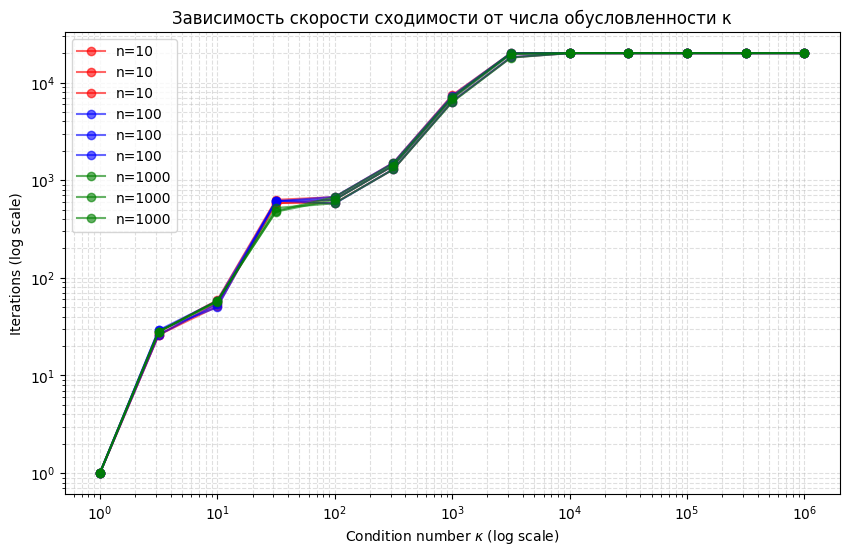

In [ ]:
def generate_diag_problem(n, kappa, random_state=None):
    rng = np.random.default_rng(random_state)
    diag = np.linspace(1.0, kappa, n)
    A = sp.diags(diag, offsets=0, format='csr')
    b = rng.normal(size=n)
    return A, b, diag

def experiment_for_n(n, kappas, repeats=3, tol=1e-6, max_iter=5000):
    results = []
    for rep in range(repeats):
        rep_res = {}
        for kappa in kappas:
            A, b, diag = generate_diag_problem(n, kappa, random_state=rep + 123)
            oracle = QuadraticOracle(A, b)
            x0 = np.zeros(n)
            line_opts = {"method": "Armijo", "c1": 1e-4, "alpha_0": 1.0}


            x_opt, msg, hist = gradient_descent_sparse(oracle, x0,
                                                       tolerance=tol,
                                                       max_iter=max_iter,
                                                       line_search_options=line_opts,
                                                       trace=True)
            iters = hist.get('iterations', max_iter)
            rep_res[kappa] = iters
        results.append(rep_res)
    return results



kappas = np.logspace(0, 6, num=13)
n_list = [10, 100, 1000]
tol = 1e-6
max_iter = 20000

all_results = {}
for n in n_list:
    print(f"▶ Running for n={n} ...")
    all_results[n] = experiment_for_n(n, kappas, tol=tol, max_iter=max_iter)


plt.figure(figsize=(10, 6))
colors = {10: 'red', 100: 'blue', 1000: 'green'}

for n in n_list:
    for rep_res in all_results[n]:
        y = [rep_res[k] for k in kappas]
        plt.plot(kappas, y, color=colors[n], alpha=0.6, marker='o', label=f"n={n}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Condition number $\kappa$ (log scale)')
plt.ylabel('Iterations (log scale)')
plt.title('Зависимость скорости сходимости от числа обусловленности κ')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

✅ Данные загружены: m=49749, n=300
▶ Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.466652, ||grad||=5.625e-01, α=1.000e+00
Iter   10: f=0.272654, ||grad||=7.546e-02, α=1.000e+00
Iter   20: f=0.240978, ||grad||=4.584e-02, α=1.000e+00
Iter   30: f=0.226148, ||grad||=3.403e-02, α=1.000e+00
Iter   40: f=0.217059, ||grad||=2.766e-02, α=1.000e+00
Iter   50: f=0.210676, ||grad||=2.369e-02, α=1.000e+00
Iter   60: f=0.205808, ||grad||=2.097e-02, α=1.000e+00
Iter   70: f=0.201889, ||grad||=1.899e-02, α=1.000e+00
Iter   80: f=0.198613, ||grad||=1.748e-02, α=1.000e+00
Iter   90: f=0.195800, ||grad||=1.628e-02, α=1.000e+00
Iter  100: f=0.193334, ||grad||=1.529e-02, α=1.000e+00
Iter  110: f=0.191142, ||grad||=1.446e-02, α=1.000e+00
Iter  120: f=0.189168, ||grad||=1.375e-02, α=1.000e+00
Iter  130: f=0.187376, ||grad||=1.313e-02, α=1.000e+00
Iter  140: f=0.185735, ||grad||=1.258e-02, α=1.000e+00
Iter  150: f=0.184225, ||grad||=1.208e-02, α=1.000e+00
Iter  160: f=0.182828, ||grad||=

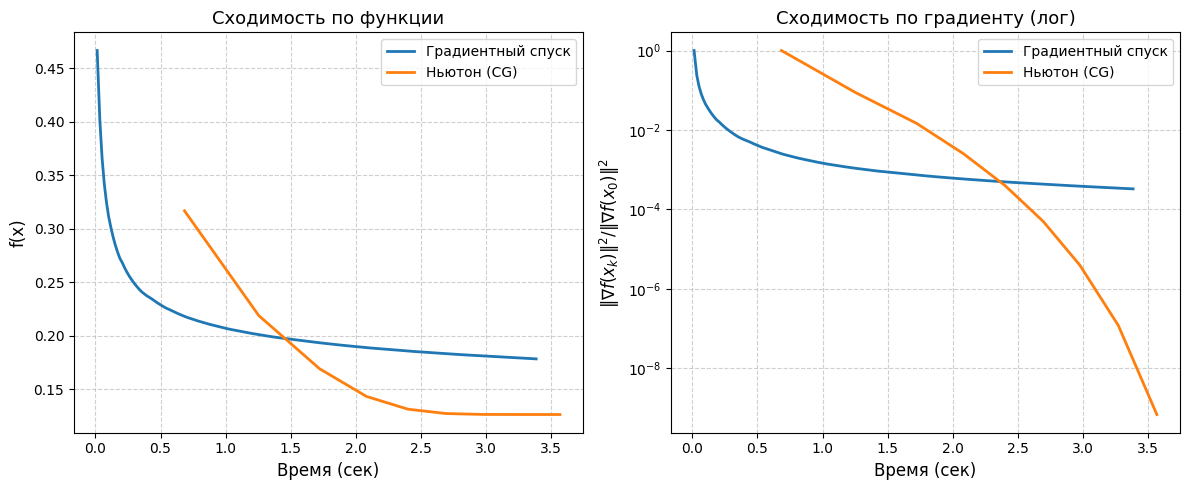

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time


X, y = load_svmlight_file("/content/w8a.txt")
m, n = X.shape
print(f"✅ Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = SparseLogRegOracle(X, y, regcoef)


x0 = np.zeros(n)


print("▶ Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("▶ Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


✅ Данные загружены: m=6000, n=5000
▶ Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.664613, ||grad||=2.556e+00, α=1.250e-01
Iter   10: f=0.299496, ||grad||=1.556e+00, α=3.906e-03
Iter   20: f=0.279056, ||grad||=1.037e+00, α=3.906e-03
Iter   30: f=0.263020, ||grad||=1.076e+00, α=3.906e-03
Iter   40: f=0.250871, ||grad||=7.299e-01, α=7.812e-03
Iter   50: f=0.238916, ||grad||=7.254e-01, α=3.906e-03
Iter   60: f=0.229441, ||grad||=5.132e-01, α=7.812e-03
Iter   70: f=0.221019, ||grad||=4.964e-01, α=7.812e-03
Iter   80: f=0.213067, ||grad||=5.398e-01, α=7.812e-03
Iter   90: f=0.206473, ||grad||=5.660e-01, α=7.812e-03
Iter  100: f=0.198929, ||grad||=4.487e-01, α=7.812e-03
Iter  110: f=0.193117, ||grad||=3.508e-01, α=1.562e-02
Iter  120: f=0.186842, ||grad||=3.100e-01, α=1.562e-02
Iter  130: f=0.180316, ||grad||=2.870e-01, α=1.562e-02
Iter  140: f=0.173874, ||grad||=2.938e-01, α=1.562e-02
Iter  150: f=0.166670, ||grad||=2.418e-01, α=3.125e-02
Iter  160: f=0.157710, ||grad||=

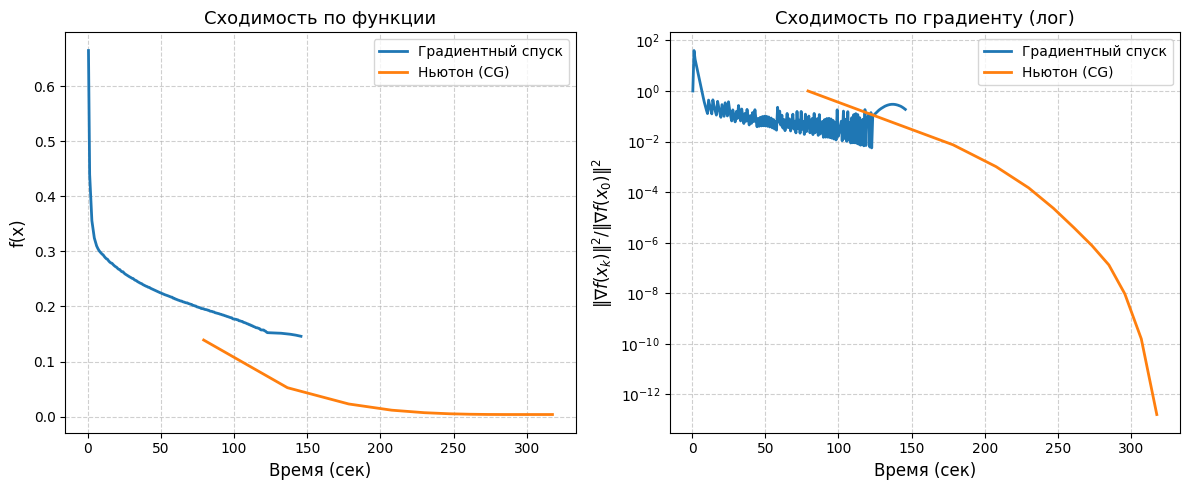

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time


X, y = load_svmlight_file("/content/gisette_scale.bz2")
m, n = X.shape
print(f"✅ Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = SparseLogRegOracle(X, y, regcoef)


x0 = np.zeros(n)


print("▶ Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("▶ Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


✅ Данные загружены: m=72309, n=20958
▶ Запуск градиентного спуска (разреженная версия)...
Iter    0: f=0.692046, ||grad||=3.321e-02, α=1.000e+00
Iter   10: f=0.681306, ||grad||=3.245e-02, α=1.000e+00
Iter   20: f=0.671048, ||grad||=3.172e-02, α=1.000e+00
Iter   30: f=0.661244, ||grad||=3.101e-02, α=1.000e+00
Iter   40: f=0.651869, ||grad||=3.033e-02, α=1.000e+00
Iter   50: f=0.642898, ||grad||=2.967e-02, α=1.000e+00
Iter   60: f=0.634307, ||grad||=2.904e-02, α=1.000e+00
Iter   70: f=0.626076, ||grad||=2.843e-02, α=1.000e+00
Iter   80: f=0.618182, ||grad||=2.785e-02, α=1.000e+00
Iter   90: f=0.610608, ||grad||=2.728e-02, α=1.000e+00
Iter  100: f=0.603333, ||grad||=2.674e-02, α=1.000e+00
Iter  110: f=0.596341, ||grad||=2.622e-02, α=1.000e+00
Iter  120: f=0.589616, ||grad||=2.572e-02, α=1.000e+00
Iter  130: f=0.583142, ||grad||=2.524e-02, α=1.000e+00
Iter  140: f=0.576906, ||grad||=2.478e-02, α=1.000e+00
Iter  150: f=0.570894, ||grad||=2.433e-02, α=1.000e+00
Iter  160: f=0.565093, ||grad|

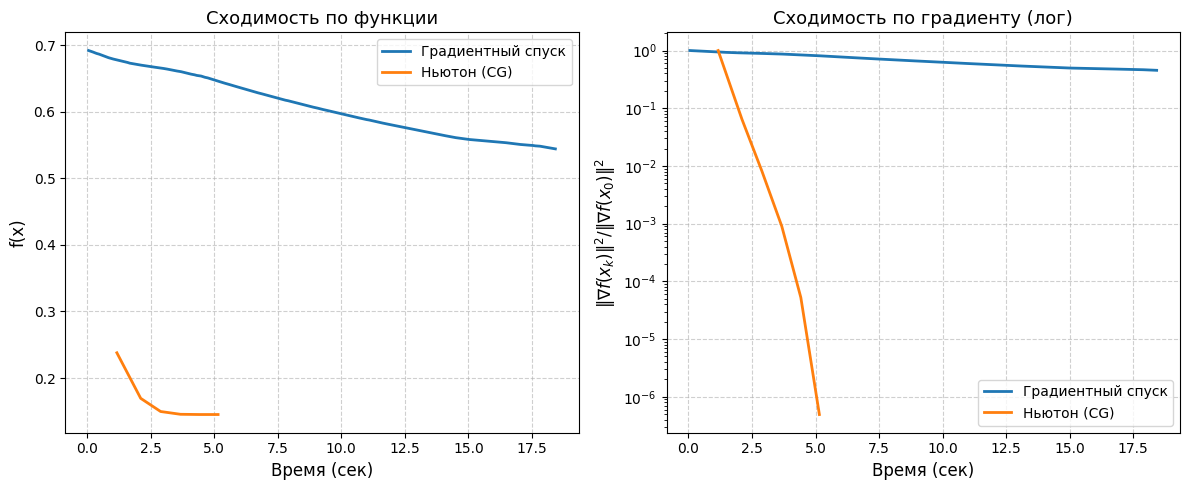

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
import time


X, y = load_svmlight_file("/content/real-sim.bz2")
m, n = X.shape
print(f"✅ Данные загружены: m={m}, n={n}")


regcoef = 1.0 / m
oracle = SparseLogRegOracle(X, y, regcoef)


x0 = np.zeros(n)


print("▶ Запуск градиентного спуска (разреженная версия)...")
x_gd, status_gd, hist_gd = gradient_descent_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=200,
    trace=True,
    display=True,
    line_search_options={'method': 'Armijo', 'alpha_0': 1.0}
)

print("▶ Запуск метода Ньютона (разреженная версия)...")
x_newton, status_newton, hist_newton = newton_sparse(
    oracle, x0,
    tolerance=1e-6,
    max_iter=20,
    trace=True,
    display=True,
    line_search_options={'method': 'Wolfe'},
    cg_tol=1e-5
)


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(hist_gd["time"], hist_gd["func"], label="Градиентный спуск", linewidth=2)
plt.plot(hist_newton["time"], hist_newton["func"], label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.title("Сходимость по функции", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


g0 = hist_gd["grad_norm"][0]
plt.subplot(1, 2, 2)
plt.semilogy(hist_gd["time"], (np.array(hist_gd["grad_norm"]) / g0) ** 2, label="Градиентный спуск", linewidth=2)
plt.semilogy(hist_newton["time"], (np.array(hist_newton["grad_norm"]) / g0) ** 2, label="Ньютон (CG)", linewidth=2)
plt.xlabel("Время (сек)", fontsize=12)
plt.ylabel(r"$\|\nabla f(x_k)\|^2 / \|\nabla f(x_0)\|^2$", fontsize=12)
plt.title("Сходимость по градиенту (лог)", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [7]:
!pip install nose-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 5.8 MB/s eta 0:00:00


In [9]:
!nosetests -v presubmit_tests.py

presubmit_tests.test_QuadraticOracle ... ok
presubmit_tests.test_gd_1d ... ok
presubmit_tests.test_gd_basic ... ok
presubmit_tests.test_grad_finite_diff_1 ... ok
presubmit_tests.test_grad_finite_diff_2 ... ok
presubmit_tests.test_hess_finite_diff_1 ... ok
presubmit_tests.test_hess_finite_diff_2 ... ok
presubmit_tests.test_line_search ... ok
presubmit_tests.test_log_reg_optimized ... ok
presubmit_tests.test_log_reg_optimized_oracle_calls ... ok
presubmit_tests.test_log_reg_oracle_calls ... ok
presubmit_tests.test_log_reg_usual ... ok
presubmit_tests.test_newton_1d ... ok
presubmit_tests.test_newton_basic ... ok
presubmit_tests.test_newton_fail ... ok
presubmit_tests.test_python3 ... ok

----------------------------------------------------------------------
Ran 16 tests in 0.031s

OK
